# __DAT-901 Customer Recommender__
_Sana AMMAR, Yannis BOUACEM, Nicolas PICHARD_ 
<br>
<br>
***
<br>


## __1. Data preparation__
 - 1.1. Import modules
 - 1.2. Import data
 
<br>

## __2. Exploring data__
 - 2.1. Delete unused vars
 - 2.2. Number of time a client bought the same item
 - 2.3. Number of client that bought the same item
 - 2.4. Pivot table client and item (weighted)
 - 2.5. Pivot table client and item
 
<br>

## __3. Processing data__
 - 3.1. Collaborative filtering
 - 3.2. Content based
 - 3.3. Hybrid NCF / CB
 - 3.4. Segmentation
 
  <br>
 

## __1. Data preparation__
_First import all module needed_
<br>

***

<br>

### 1.2. Import modules

In [2]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import csv
import os
import datetime
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

#preprocessing
from sklearn.preprocessing import OrdinalEncoder

sns.set()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### 1.2. Import data

In [3]:
filename = "KaDo_less.csv"

#Return DataFrame
df = pd.read_csv(filename, encoding="utf8")

#Display df dimensions
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (10000, 8)


,FAMILLE,PRIX_NET
1864,CAPILLAIRES,1.50
397,CAPILLAIRES,2.45
2499,CAPILLAIRES,2.45
3556,CAPILLAIRES,2.45
4041,CAPILLAIRES,2.45
...,...,...
8822,SOLAIRES,18.00
3876,SOLAIRES,18.95
440,SOLAIRES,23.50
6763,SOLAIRES,23.50


<Figure size 2160x720 with 0 Axes>

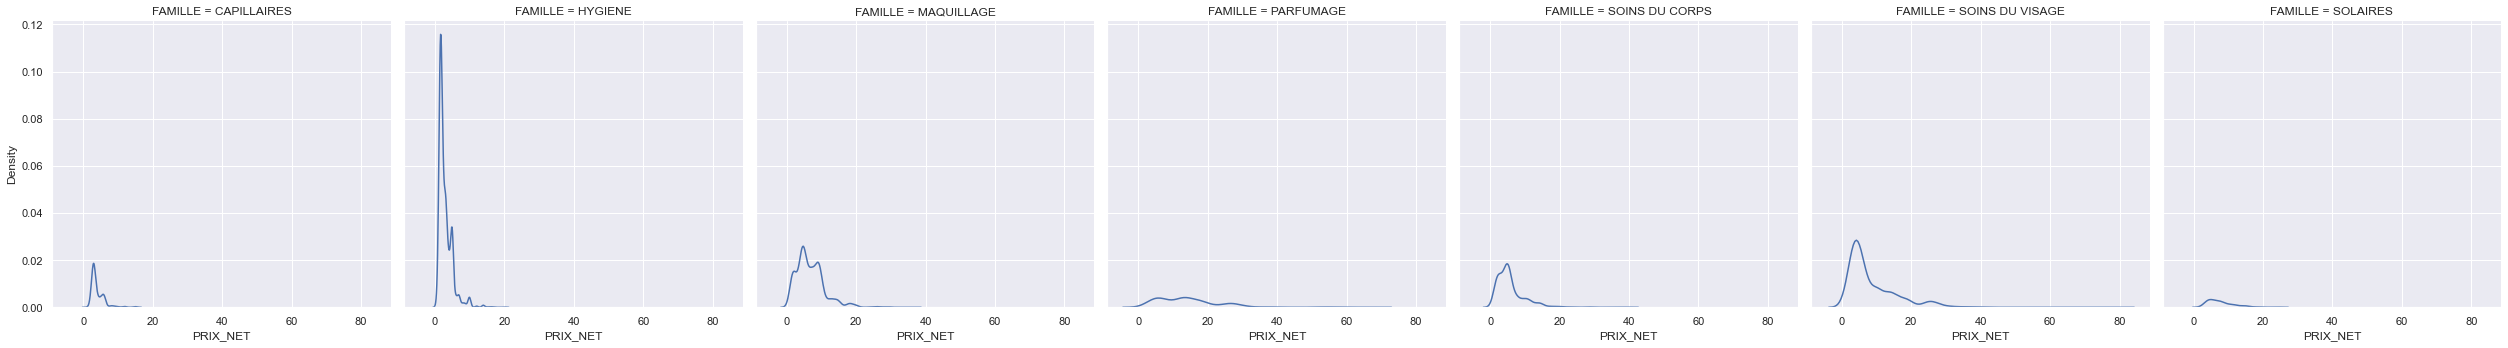

In [7]:
df_famille_prix = df[["FAMILLE", "PRIX_NET"]].sort_values(by=['FAMILLE', 'PRIX_NET'])
display(df_famille_prix)

fig = plt.figure(figsize = (30, 10))
sns.displot(
    data = df_famille_prix,
    col = "FAMILLE",
    x = "PRIX_NET",
    kind = "kde",
)



In [ ]:
print('Max price:', max(df.PRIX_NET))
print('Min price:', min(df.PRIX_NET))
print('Median price:', df.PRIX_NET.median())
print('Mean price:', df.PRIX_NET.mean())

In [ ]:
# Give some infos types/null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

## __2. Preprocessing__
_Segment data, try to understand and display particular indicator_

***
<br>

In [ ]:

def clean_data(df_clean):
    #drop TICKET_ID
    features = ["MOIS_VENTE", "PRIX_NET", "FAMILLE", "UNIVERS", "MAILLE", "LIBELLE", "CLI_ID"]

    #create ordinal encoder to transform categoricals features
    ordinal_encoder = OrdinalEncoder()
    cat_cols = ["FAMILLE", "UNIVERS", "MAILLE"]
    df_clean[cat_cols] = ordinal_encoder.fit_transform(df_clean[cat_cols])

    return df_clean[features]

In [ ]:
df_to_clean = df.copy()
df_train = clean_data(df_to_clean)
df_collab = df_train.drop(columns=['MOIS_VENTE', 'PRIX_NET','FAMILLE' ,'UNIVERS' ,'MAILLE'])
df_train.head()

In [ ]:
display(max(df_train["UNIVERS"]))

## __3. Exploring data__
_Analyse, understand and display particular indicator_

***
<br>


In [ ]:
months = ["January", "February", "March", "April", "May", "June", "Jully", "August", "September", "October", "November", "December"]
df_months = df_train["MOIS_VENTE"].value_counts().sort_index()
df_months.index = months

ax = plt.bar(
    df_months.index,
    height = df_months.values
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Mois")
plt.ylabel("Nombre d'achats")


In [ ]:
df_familles = df["FAMILLE"].value_counts()

ax = plt.bar(
    df_familles.index,
    height = df_familles.values
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Famille")
plt.ylabel("Nombre d'achats")


In [ ]:
fig = plt.figure(figsize = (15, 5))
month = 1
df_month = df.loc[df_train["MOIS_VENTE"] == month]["FAMILLE"].value_counts()

ax = plt.bar(
    df_month.index,
    height = df_month.values
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Famille")
plt.ylabel("Nombre d'achats")
plt.title(months[month - 1])



In [ ]:
df_mean_command = df.groupby(["CLI_ID", "TICKET_ID"], as_index=False)["PRIX_NET"].sum().groupby("CLI_ID")["PRIX_NET"].mean()
df_num_command = df.groupby(["CLI_ID"])["TICKET_ID"].count()
df_command = pd.concat([df_mean_command, df_num_command], axis = 1)
df_command = df_command.rename(columns = {'PRIX_NET': 'MEAN', 'TICKET_ID': 'COUNT'})
ax = sns.regplot(x = df_command["MEAN"], y =  df_command["COUNT"], fit_reg = False)
ax.set(
    xlabel = "Prix moyen par commande (en €)",
    ylabel = "Nombre de commandes par client"
)
display(df_command.shape)

In [ ]:
ax = sns.violinplot(x=df_mean_command)
ax.set(
    xlabel = "Prix moyen par commande (en €)"
)

In [ ]:
ax = sns.violinplot(x=df_num_command)
ax.set(
    xlabel = "Nombre commandes par client"
)

In [ ]:
#return commands from a client_id
client_id = 1490281
display(df.loc[df["CLI_ID"] == client_id])

In [ ]:
#return command from a ticket_id
ticket_id = 35592159
display(df.loc[df["TICKET_ID"] == ticket_id])

### 3.1. Quantity of LIBELLE a CLI_ID bought

In [ ]:
qte_libelle = pd.DataFrame(df_collab.value_counts()).reset_index()
qte_libelle.columns = ['LIBELLE', 'CLI_ID', 'COUNT']
display(qte_libelle)

### 3.2. Pivot table client and item (weighted)
_We count every time a client bought an item and use it as a feedback_

In [ ]:
#Create df with CLI_ID as column, LIBELLE as row and COUNT as values
pivot_weight_df = qte_libelle.pivot_table(index = 'CLI_ID', columns='LIBELLE', fill_value = 0)
array_weight_pivot = pivot_weight_df.to_numpy()

pivot_weight_df.head()

### 3.3. Pivot table client and item 
_We assume that if a client bought an item, it's an implicite feedback. However we don't quantify it (1/0)_

In [ ]:
#Change weight values to 1
qte_libelle["COUNT"].loc[qte_libelle["COUNT"] > 1] = 1

#Create df with CLI_ID as column, LIBELLE as row and COUNT as values
pivot_df = qte_libelle.pivot_table(index = 'CLI_ID', columns='LIBELLE', values = 'COUNT', fill_value = 0)
array_pivot = pivot_df.to_numpy()

pivot_df.head()

# __4. Processing data__
_Use different models to process data and create a recommender system_

***
<br>

### 3.1. Collaborative filtering

In [ ]:
# Create an array of every entry the pivot table has
def wide_to_long(wide, ratings):
    
    def _get_ratings(arr, rating):
        idx = np.where(arr == rating)
        return np.vstack(
            (idx[0], idx[1], np.ones(idx[0].size, dtype="int8") * rating)
        ).T

    long_arrays = []
    for r in ratings:
        long_arrays.append(_get_ratings(wide, r))

    return np.vstack(long_arrays)

In [ ]:
long = wide_to_long(array_pivot, np.unique(array_pivot))
df = pd.DataFrame(long, columns=["CLI_ID", "LIBELLE", "interaction"])

long_weight = wide_to_long(array_weight_pivot, np.unique(array_weight_pivot))
df_weight = pd.DataFrame(long_weight, columns=["CLI_ID", "LIBELLE", "interaction"])

In [ ]:
#We try to reduce the interaction weight
df_weight_red = pd.DataFrame(df_weight, columns=["CLI_ID", "LIBELLE", "interaction"])
df_weight_red["interaction"] = np.sqrt(df_weight["interaction"])

### Model

In [ ]:
# Define K as the number of item we want, and N_EPOCHS as the number of epochs we'll do
TOP_K = 5
N_EPOCHS = 10

In [ ]:
# Define the neural collabirative filter
def create_ncf(
    nb_users: int,
    nb_items: int,
    latent_dim_mf: int = 4,
    latent_dim_mlp: int = 32,
    reg_mf: int = 0,
    reg_mlp: int = 0.01,
    
    dense_layers: List[int] = [8, 4],
    reg_layers: List[int] = [0.01, 0.01],
    activation_dense: str = "relu",
) -> keras.Model:

    # input layer
    user = Input(shape=(), dtype="int64", name="CLI_ID")
    item = Input(shape=(), dtype="int64", name="LIBELLE")

    # embedding layers
    mf_user_embedding = Embedding(
        input_dim=nb_users,
        output_dim=latent_dim_mf,
        name="mf_user_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mf),
        input_length=1,
    )
    mf_item_embedding = Embedding(
        input_dim=nb_items,
        output_dim=latent_dim_mf,
        name="mf_item_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mf),
        input_length=1,
    )

    mlp_user_embedding = Embedding(
        input_dim=nb_users,
        output_dim=latent_dim_mlp,
        name="mlp_user_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mlp),
        input_length=1,
    )
    mlp_item_embedding = Embedding(
        input_dim=nb_items,
        output_dim=latent_dim_mlp,
        name="mlp_item_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mlp),
        input_length=1,
    )

    # Matrix Factorisation vector
    mf_user_latent = Flatten()(mf_user_embedding(user))
    mf_item_latent = Flatten()(mf_item_embedding(item))
    mf_cat_latent = Multiply()([mf_user_latent, mf_item_latent])

    # Multi-Layer Perceptron vector
    mlp_user_latent = Flatten()(mlp_user_embedding(user))
    mlp_item_latent = Flatten()(mlp_item_embedding(item))
    mlp_cat_latent = Concatenate()([mlp_user_latent, mlp_item_latent])

    mlp_vector = mlp_cat_latent

    # Build dense layers for model
    for i in range(len(dense_layers)):
        layer = Dense(
            dense_layers[i],
            activity_regularizer=l2(reg_layers[i]),
            activation=activation_dense,
            name="layer%d" % i,
        )
        mlp_vector = layer(mlp_vector)

    predict_layer = Concatenate()([mf_cat_latent, mlp_vector])

    result = Dense(
        1, activation="sigmoid", kernel_initializer="lecun_uniform", name="interaction"
    )

    output = result(predict_layer)

    model = Model(
        inputs=[user, item],
        outputs=[output],
    )

    return model

In [ ]:
n_users, n_items = pivot_df.shape

print(n_users)
print(n_items)

ncf_model = create_ncf(n_users, n_items)

ncf_model.compile(
    optimizer=Adam(),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)
ncf_model._name = "neural_collaborative_filtering"
ncf_model.summary()

### TensorFlow Dataset

In [ ]:
def make_tf_dataset(df, targets, val_split = 0.1):
    #batch_size: batch size for training
    batch_size = 512
    #seed: random seed for shuffling data - `None` won't shuffle the data
    seed = 0

    n_val = round(df.shape[0] * val_split)
    if seed:
        # shuffle all the rows
        x = df.sample(frac=1, random_state=seed).to_dict("series")
    else:
        x = df.to_dict("series")
    y = dict()
    for t in targets:
        y[t] = x.pop(t)
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds_val = ds.take(n_val).batch(batch_size)
    ds_train = ds.skip(n_val).batch(batch_size)
    return ds_train, ds_val

In [ ]:
ds_train, ds_val = make_tf_dataset(df_weight_train, ["interaction"])

### Train model

In [ ]:
train_hist = ncf_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=N_EPOCHS,
)

### Predictions

In [ ]:
long_test = wide_to_long(array_weight_pivot, np.unique(array_pivot))
df_test = pd.DataFrame(long_test, columns=["CLI_ID", "LIBELLE", "interaction"])
ds_test, _ = make_tf_dataset(df_test, ["interaction"], val_split = 0)

In [ ]:
ncf_predictions = ncf_model.predict(ds_test)
df_test["ncf_predictions"] = ncf_predictions
print(df_test)

In [ ]:
display(df_test)

Compute back to user ID

In [ ]:
df_test_clean = df_test.drop(columns = ["interaction"])
table_test = pd.pivot_table(data = df_test_clean, index = "CLI_ID", columns = "LIBELLE", values = "ncf_predictions")

table_test.columns = pivot_df.columns
table_test.index = pivot_df.index

display(table_test.head().round(2))

In [ ]:
rec_items = table_test.idxmax(axis="columns")
percent_rec = table_test.max(axis = "columns")

In [ ]:
percent_rec.loc[percent_rec >= 0.5]

In [ ]:
fig = plt.figure(figsize = (16,10))

sns.barplot(percent_rec.index, percent_rec.values)

In [ ]:
std = df_test.describe().loc["std", "ncf_predictions"]
if std < 0.01:
    raise ValueError("Model predictions have standard deviation of less than 1e-2.")

In [ ]:
# Transform prediction back to pivot table
data_ncf_prediction = df_test.pivot(
    index="CLI_ID", columns="LIBELLE", values="ncf_predictions"
).values
print("Neural collaborative filtering predictions")
print(data_ncf_prediction[1][:10])

In [ ]:
#Now we need to get the CLI_ID and LIBELLE back
cli_id = pd.DataFrame(df_clean.LIBELLE.unique())
libelle_id = pd.DataFrame(df_clean.CLI_ID.unique())

In [ ]:
max_id = table_test.idxmax(axis="columns")
index_libelle_max = table_test.idxmax(axis="columns")

user_id = 1490281

user_id_recommend = libelle_id[libelle_id == user_id].index[0]
recommender_score = recommend_max[user_id_recommend]
recommender_libelle = libelle_index[max_id[user_id_recommend]]

display(recommender_libelle)

user_libelle = pd.DataFrame( pivot_weight_df, columns = [recommender_libelle])
for item in user_libelle:
    if item == 1490281:
        print("same same")
print(user_libelle)

### 3.2. Content based

### 3.3. Hydrid NCF / CB

### 3.4. Segmentation

In [ ]:
from sklearn.cluster import KMeans

X = df_command
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
display(kmeans.labels_.shape)
display(kmeans.labels_)
display(kmeans.cluster_centers_)
df_command["CAT"] = kmeans.labels_
display(df_command.head())

ax = sns.lmplot(x = "MEAN", y =  "COUNT", data = df_command, fit_reg = False, hue = "CAT")
ax.set(
    xlabel = "Prix moyen par commande (en €)",
    ylabel = "Nombre de commandes par client"
)

In [ ]:
inertia = []
K_range = range(1, 20)

for K in K_range:
    model = KMeans(n_clusters = K).fit(X)
    inertia.append(model.inertia_)

In [ ]:
plt.plot(K_range, inertia)